In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
mypath = '11en20' #path with files to analyze
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')
np.random.seed(0)

In [2]:
prop = 1.0

In [3]:
def new_cases_per_day(fecha_sintomas,pop,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    latest update = checked the days again, it works perfectly splendid
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        casos_por_dia[:,1] = casos_por_dia[:,1]*(100000/pop)
        return casos_por_dia  

In [4]:
def sum_last14(casos):
    #latest update = checked the days again, it works perfectly splendid
    ac_por_dia = np.copy(casos)
    for i in casos[:,0]-casos[0,0]:
        index = np.copy(casos[casos[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [5]:
def first_solution(n_t,a,b,c,d,e):
    prox_dia = n_t.shape[0]
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a*n_t[i-6,1] + b*n_t[i-5,1] + c*n_t[i-4,1] + d*n_t[i-3,1] + e*n_t[i-2,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = max(min(((n_t[i-1,1] + n_t[i,1] + n_t[i+1,1])/(aux)),4),0) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    r_def = np.copy(r_t_seven)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    return p_t[:-7]
    
    

In [6]:
def second_solution(n_t,a,b,c):
    prox_dia = n_t.shape[0]
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a*n_t[i-6,1] + b*n_t[i-5,1] + c*n_t[i-4,1]  #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        #################### ACAAAAAAAAAAAAAAAAAA ###############################################################
        r_t[i,1] = max(min(((n_t[i-1,1] + n_t[i,1] + n_t[i+1,1])/(aux)),4),0) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    r_def = np.copy(r_t_seven)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    return p_t[:-7]
    
    

In [20]:
def third_solution(n_t,a,b,c,d,e):
    prox_dia = n_t.shape[0]
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a*n_t[i-6,1] + b*n_t[i-5,1] + c*n_t[i-4,1] + d*n_t[i-3,1] + e*n_t[i-7,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = max(min(((n_t[i-1,1] + n_t[i,1] + n_t[i+1,1])/(aux)),4),0) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    r_def = np.copy(r_t_seven)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    return p_t[:-7]
    

In [8]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)

In [9]:
def fit_and_test_3weights(file,pop):
    data = pd.read_csv(file,sep=",",quotechar='"',
            parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
    df = pd.DataFrame(data) #converting to dataframe for use
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    fecha_sintomas = fecha_sintomas - min(fecha_sintomas)
    fecha_sintomas = fecha_sintomas[fecha_sintomas<=max(fecha_sintomas)-10]
    fecha_sintomas_2 = np.copy(fecha_sintomas[fecha_sintomas<=round(max(fecha_sintomas)*prop)])
    resto = max(fecha_sintomas) - round(max(fecha_sintomas)*prop)
    casos_por_dia = new_cases_per_day(fecha_sintomas,pop,graph = False,ret=True)
    cases = np.copy(casos_por_dia)
    casos_por_dia_2 = new_cases_per_day(fecha_sintomas_2,pop,graph = False,ret=True)
    cases_2 = np.copy(casos_por_dia_2)
    predicted = second_solution(casos_por_dia,1,1,1)
    predicted_2 = second_solution(casos_por_dia_2,1,1,1)
    res = sum_last14(cases)[:,1]
    smse1 = np.linalg.norm(predicted-res[20:])
    res_2 = sum_last14(cases_2)[:,1]
    p0 = 1,1,1
    k, cov = curve_fit(second_solution, casos_por_dia_2, res_2[20:],p0)
    predicted2 = second_solution(casos_por_dia,k[0],k[1],k[2])
    #plt.figure()
    res = sum_last14(cases)[:,1]
    #plt.plot(res[20:],label='Activos medidos')
    #plt.plot(predicted2,'r--',linewidth=3,label='Activos predichos una semana antes')
    #plt.title('Optimizado',fontsize=14)
    #plt.xlabel('Días desde el primer caso')
    #plt.ylabel('Casos activos sintomáticos / 100mil habitantes')
    #plt.legend(fontsize=12)
    #plt.show()
    smse2 = np.linalg.norm(predicted2-res[20:])
    diff = smse2-smse1
    #diff_test = np.linalg.norm(res[-resto:]-predicted2[-resto:]) - np.linalg.norm(res[-resto:]-predicted[-resto:])
    return k,cov,diff#,diff_test

In [10]:
def fit_and_test_5weights(file,pop):
    data = pd.read_csv(file,sep=",",quotechar='"',
            parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
    df = pd.DataFrame(data) #converting to dataframe for use
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    fecha_sintomas = fecha_sintomas - min(fecha_sintomas)
    fecha_sintomas = fecha_sintomas[fecha_sintomas<=max(fecha_sintomas)-10]
    fecha_sintomas_2 = np.copy(fecha_sintomas[fecha_sintomas<=round(max(fecha_sintomas)*prop)])
    resto = max(fecha_sintomas) - round(max(fecha_sintomas)*prop)
    casos_por_dia = new_cases_per_day(fecha_sintomas,pop,graph = False,ret=True)
    cases = np.copy(casos_por_dia)
    casos_por_dia_2 = new_cases_per_day(fecha_sintomas_2,pop,graph = False,ret=True)
    cases_2 = np.copy(casos_por_dia_2)
    predicted = second_solution(casos_por_dia,1,1,1)
    predicted_2 = second_solution(casos_por_dia_2,1,1,1)
    res = sum_last14(cases)[:,1]
    smse1 = np.linalg.norm(predicted-res[20:])
    res_2 = sum_last14(cases_2)[:,1]
    p0 = 1,1,1,0,0
    k, cov = curve_fit(first_solution, casos_por_dia_2, res_2[20:])
    predicted2 = first_solution(casos_por_dia,k[0],k[1],k[2],k[3],k[4])
    #plt.figure()
    res = sum_last14(cases)[:,1]
    #plt.plot(res[20:],label='Activos medidos')
    #plt.plot(predicted2,'r--',linewidth=3,label='Activos predichos una semana antes')
    #plt.title('Optimizado',fontsize=14)
    #plt.xlabel('Días desde el primer caso')
    #plt.ylabel('Casos activos sintomáticos / 100mil habitantes')
    #plt.legend(fontsize=12)
    #plt.show()
    smse2 = np.linalg.norm(predicted2-res[20:])
    diff = smse2-smse1
    #diff_test = np.linalg.norm(res[-resto:]-predicted2[-resto:]) - np.linalg.norm(res[-resto:]-predicted[-resto:])
    return k,cov,diff#,diff_test

In [11]:
def test_3weights(file,k,plot=False,pop=float(100000)):
    data = pd.read_csv(file,sep=",",quotechar='"',
            parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
    df = pd.DataFrame(data) #converting to dataframe for use
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    fecha_sintomas = fecha_sintomas - min(fecha_sintomas)
    fecha_sintomas = fecha_sintomas[fecha_sintomas<=max(fecha_sintomas)-10]
    fecha_sintomas_2 = np.copy(fecha_sintomas[fecha_sintomas<=round(max(fecha_sintomas)*prop)])
    resto = max(fecha_sintomas) - round(max(fecha_sintomas)*prop)
    casos_por_dia = new_cases_per_day(fecha_sintomas,pop,graph = False,ret=True)
    cases = np.copy(casos_por_dia)
    casos_por_dia_2 = new_cases_per_day(fecha_sintomas_2,pop,graph = False,ret=True)
    cases_2 = np.copy(casos_por_dia_2)
    predicted = second_solution(casos_por_dia,1,1,1)
    predicted_2 = second_solution(casos_por_dia_2,1,1,1)
    res = sum_last14(cases)[:,1]
    smse1 = np.mean(np.abs(predicted-res[20:]))
    res_2 = sum_last14(cases_2)[:,1]
    predicted2 = second_solution(casos_por_dia,k[0],k[1],k[2])
    res = sum_last14(cases)[:,1]
    smse2 = np.mean(np.abs(predicted2-res[20:]))
    diff = smse2-smse1
    print(smse2,smse1)
    if plot == True:
        plt.plot(res[20:],label='Activos medidos')
        plt.plot(predicted2,'r--',linewidth=3,label='Activos predichos una semana antes')
        plt.title('Optimizado',fontsize=14)
        plt.xlabel('Días desde el primer caso')
        plt.ylabel('Casos activos sintomáticos / 100mil habitantes')
        plt.legend(fontsize=12)
        plt.show()
    return diff

In [12]:
def test_5weights(file,k,plot=False,pop=float(100000)):
    data = pd.read_csv(file,sep=",",quotechar='"',
            parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
    df = pd.DataFrame(data) #converting to dataframe for use
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    fecha_sintomas = fecha_sintomas - min(fecha_sintomas)
    fecha_sintomas = fecha_sintomas[fecha_sintomas<=max(fecha_sintomas)-10]
    fecha_sintomas_2 = np.copy(fecha_sintomas[fecha_sintomas<=round(max(fecha_sintomas)*prop)])
    resto = max(fecha_sintomas) - round(max(fecha_sintomas)*prop)
    casos_por_dia = new_cases_per_day(fecha_sintomas,pop,graph = False,ret=True)
    cases = np.copy(casos_por_dia)
    casos_por_dia_2 = new_cases_per_day(fecha_sintomas_2,pop,graph = False,ret=True)
    cases_2 = np.copy(casos_por_dia_2)
    predicted = second_solution(casos_por_dia,1,1,1)
    predicted_2 = second_solution(casos_por_dia_2,1,1,1)
    res = sum_last14(cases)[:,1]
    smse1 = np.linalg.norm(predicted-res[20:])
    res_2 = sum_last14(cases_2)[:,1]
    predicted2 = third_solution(casos_por_dia,k[0],k[1],k[2],k[3],k[4])
    res = sum_last14(cases)[:,1]
    smse2 = np.linalg.norm(predicted2-res[20:])
    diff = smse2-smse1
    if plot == True:
        plt.plot(res[20:],label='Activos medidos')
        plt.plot(predicted2,'r--',linewidth=3,label='Activos predichos una semana antes')
        plt.title('Optimizado',fontsize=14)
        plt.xlabel('Días desde el primer caso')
        plt.ylabel('Casos activos sintomáticos / 100mil habitantes')
        plt.legend(fontsize=12)
        plt.show()
    return diff

In [13]:
#files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
#i = 0
#pop = np.array([45376763,163743,17541141,3075646,1204541,3760450,1385961,770881,393531,1990338,664057,747610,1424397,365698,3536418,173432,1694656])
#for file in files:
#    print(file)
#    k,cov,diff,diff_test = fit_and_test_3weights(mypath+'/'+file,pop[i])
#    print('coef:',k,'diff:',round(diff,2),'test diff:',round(diff_test,1))
#    i = i+1

In [14]:
#files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
#i = 0
#pop = np.array([45376763,163743,17541141,3075646,1204541,3760450,1385961,770881,393531,1990338,664057,747610,1424397,365698,3536418,173432,1694656])
#for file in files:
#    print(file)
#    k,cov,diff,diff_test = fit_and_test_5weights(mypath+'/'+file,pop[i])
#    print('coef:',k,'diff:',round(diff,2),'test diff:',round(diff_test,1))
#    i = i+1

In [15]:
file = "CasosCovid19_arg.txt"
pop = np.array([45376763,163743,17541141,3075646,1204541,3760450,1385961,770881,393531,1990338,664057,747610,1424397,365698,3536418,173432,1694656])
#pop = np.array([100000])
#k,cov,diff= fit_and_test_3weights(mypath+'/'+file,pop[0])
#print('control',diff)

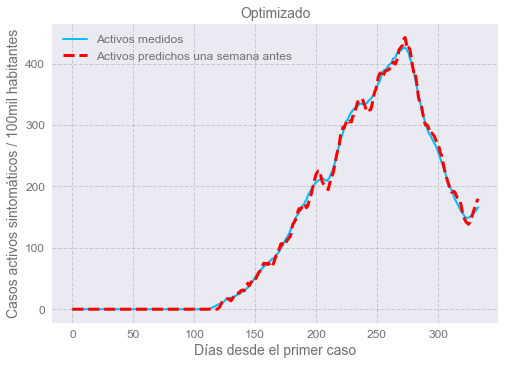

Covid19_arg ---- diff: -27.52525390183463


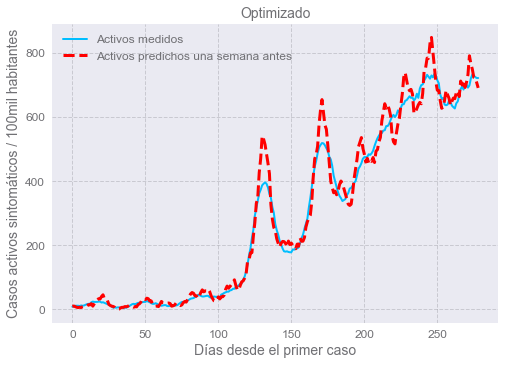

_Bariloche ---- diff: 51.40228109276313


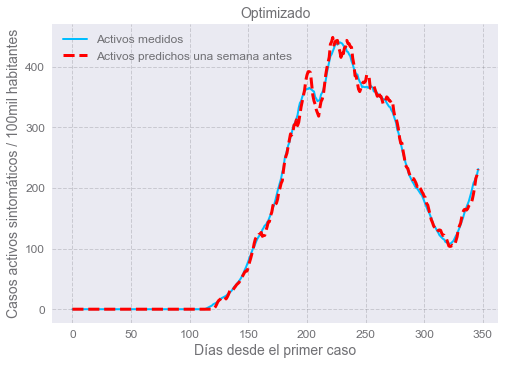

_Buenos Aires ---- diff: -30.71142583015856


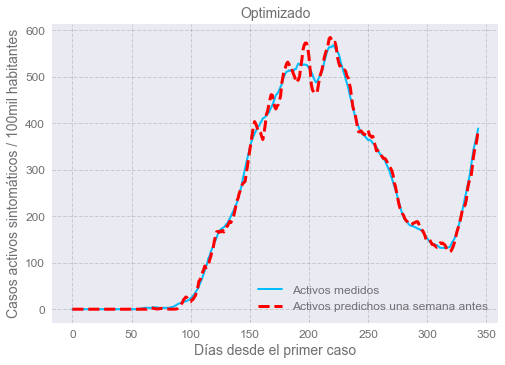

_CABA ---- diff: -48.56952820359828


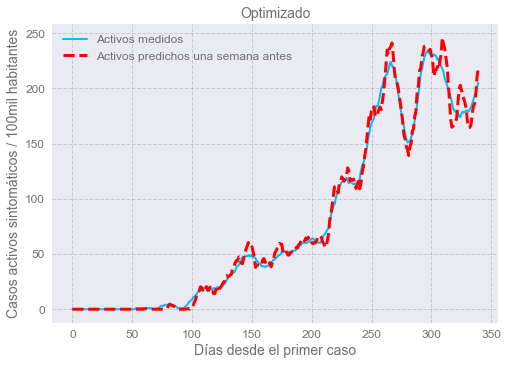

_Chaco ---- diff: -6.276481780797894


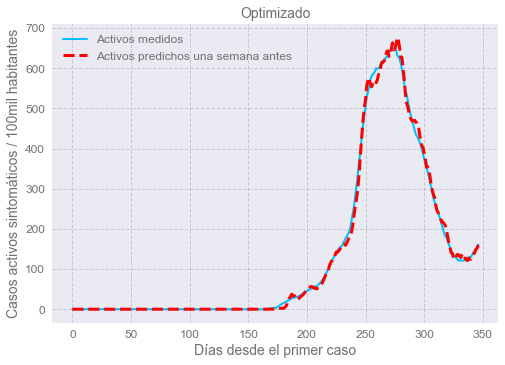

_Córdoba ---- diff: -72.3740496474075


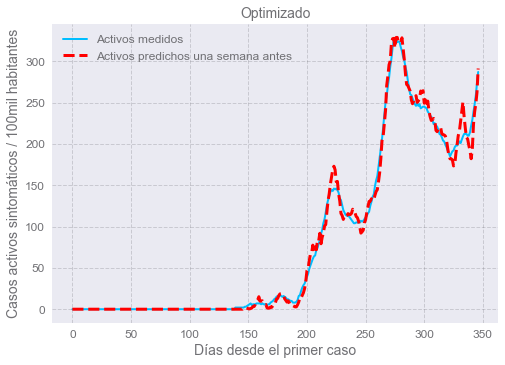

_Entre Ríos ---- diff: -15.271488569293808


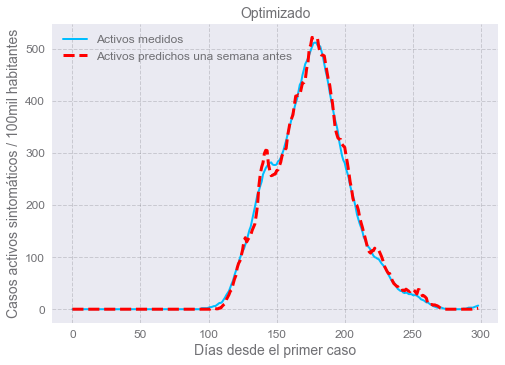

_Jujuy ---- diff: -47.474926693098325


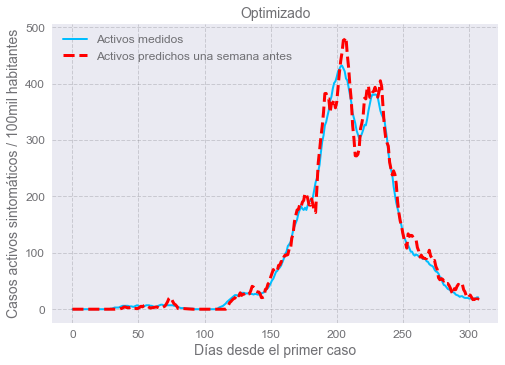

_La Rioja ---- diff: 9.869238309710852


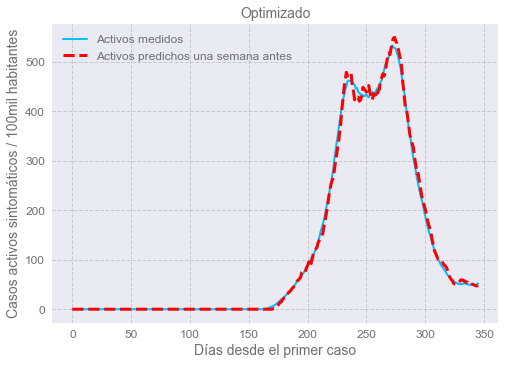

_Mendoza ---- diff: -60.115585142472554


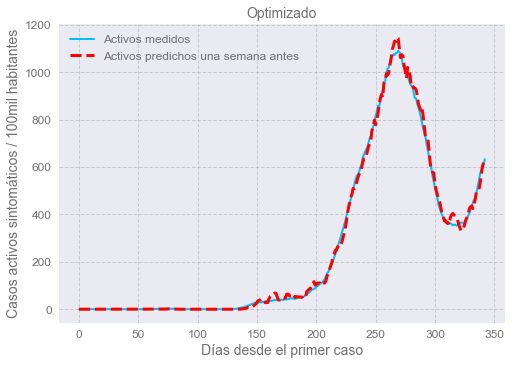

_Neuquén ---- diff: -87.21372922340043


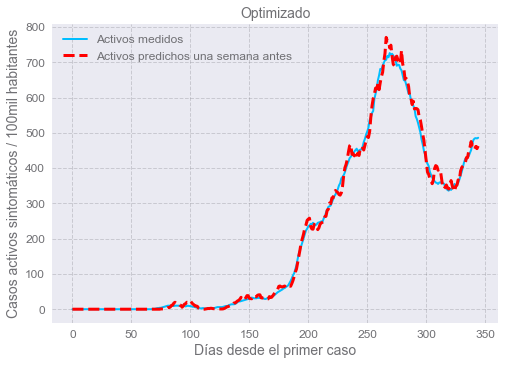

_Río Negro ---- diff: -32.978300884189196


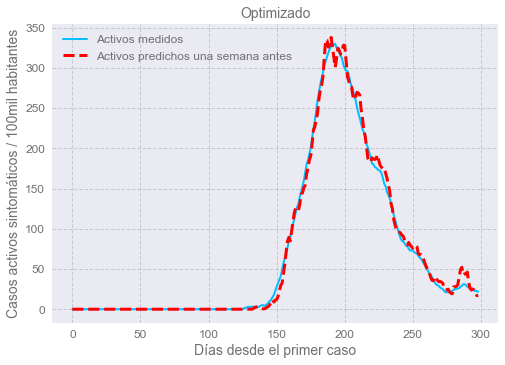

_Salta ---- diff: -31.148498489982245


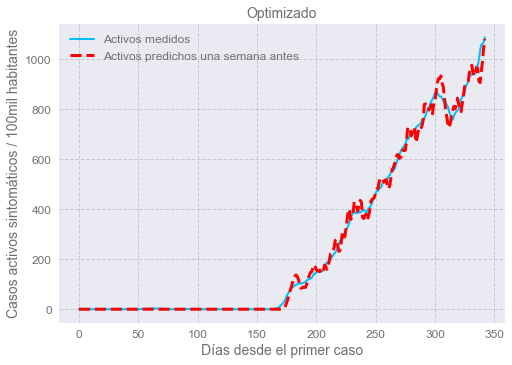

_Santa Cruz ---- diff: 2.0955171027166557


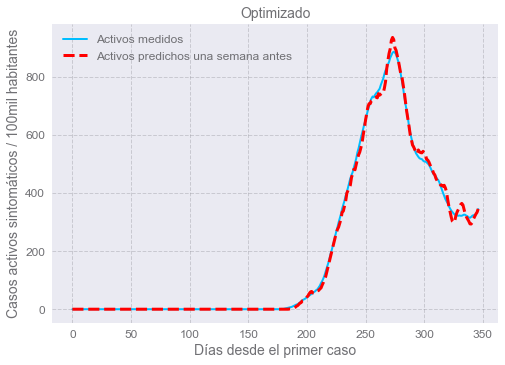

_Santa Fe ---- diff: -93.01267201989586


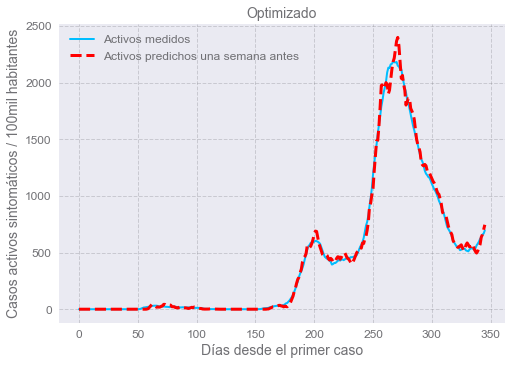

_Tierra del Fuego ---- diff: -248.1345541359583


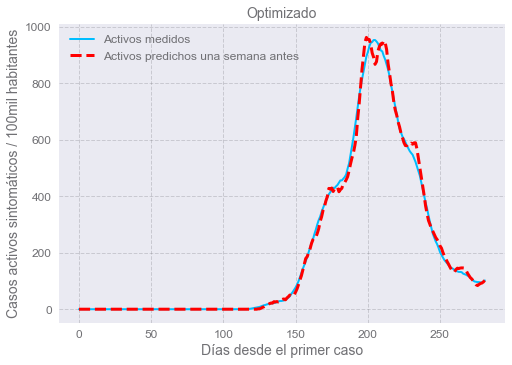

_Tucumán ---- diff: -95.58669067035731


In [21]:
np.random.seed(0)
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
i = 0
k =  [-0.67170817, #i-6
       -0.30282897, #i-5
       -0.14124513, #i-4
        1.1792158, #i-3
        2.946493] #i-7
for file in files:
    diff = test_5weights(mypath+'/'+file,k,plot=True,pop=pop[i])
    print(file[5:-4],'---- diff:',diff)
    i = i + 1

In [22]:
k

[-0.67170817, -0.30282897, -0.14124513, 1.1792158, 2.946493]